In [1]:
%matplotlib inline
import collections
from sklearn import preprocessing
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import shutil

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Read the data

In [2]:
path = "./"

#Read the training and test datasets
filename_read1 = os.path.join(path,"UNSW_NB15_training-set_csc215.csv")
df_training = pd.read_csv(filename_read1, na_values=['NA','?'])

filename_read2 = os.path.join(path,"UNSW_NB15_test-set_csc215.csv")
df_test = pd.read_csv(filename_read2, na_values=['NA','?'])

print("Training data shape:", df_training.shape)
print("Test_data",df_test.shape)

Training data shape: (175341, 45)
Test_data (82332, 45)


# Data processing

In [3]:
#return rows with null value in training dataset
df_training[df_training.isnull().any(axis=1)]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label


In [4]:
#return rows with null value in test dataset
df_test[df_test.isnull().any(axis=1)]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label


In [5]:
#remove special character 
ind=df_training[df_training['service']=='-'].index
df_training.drop(ind, inplace=True)

ind=df_test[df_test['service']=='-'].index
df_test.drop(ind, inplace=True)

print('Training set: ',df_training.shape)
print("Testing set: ",df_test.shape)

Training set:  (81173, 45)
Testing set:  (35179, 45)


In [6]:
#filter data by dropping columns
df_training.drop(['rate','ct_src_ltm','ct_dst_ltm','trans_depth','dur','swin','dwin','sjit','djit','id'],axis=1,inplace=True)
df_test.drop(['rate','ct_src_ltm','ct_dst_ltm','trans_depth','dur','swin','dwin','sjit','djit','id'],axis=1,inplace=True)

print('Training set: ',df_training.shape)
print("Testing set: ",df_test.shape)

Training set:  (81173, 35)
Testing set:  (35179, 35)


In [7]:
df_training

,proto,service,state,spkts,dpkts,sbytes,dbytes,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_srv_dst,is_sm_ips_ports,attack_cat,label
3,tcp,ftp,FIN,12,12,628,770,62,252,2.740179e+03,...,1,1,3,1,1,0,1,0,Normal,0
11,tcp,smtp,FIN,62,28,56329,2212,62,252,2.118251e+05,...,1,1,2,0,0,0,1,0,Normal,0
15,udp,snmp,INT,2,0,138,0,254,0,2.760000e+08,...,1,1,4,0,0,0,1,0,Normal,0
17,tcp,http,FIN,10,8,860,1096,62,252,1.573347e+04,...,1,1,2,0,0,1,3,0,Normal,0
21,tcp,http,FIN,10,6,998,268,254,252,2.127704e+04,...,1,1,1,0,0,1,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175335,udp,dns,INT,2,0,114,0,254,0,7.600000e+07,...,33,17,45,0,0,0,45,0,Generic,1
175336,udp,dns,INT,2,0,114,0,254,0,5.066666e+07,...,24,13,24,0,0,0,24,0,Generic,1
175338,udp,dns,INT,2,0,114,0,254,0,5.066666e+07,...,3,3,13,0,0,0,12,0,Generic,1
175339,udp,dns,INT,2,0,114,0,254,0,5.066666e+07,...,30,14,30,0,0,0,30,0,Generic,1


In [8]:
#one-hot encoding
def en_txt_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
# Encode text values to indexes, i.e. label encoding
def en_txt_indx(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

In [9]:
#encoding training data
attack_cat = en_txt_dummy(df_training, "attack_cat")
ct_state_ttl = en_txt_dummy(df_training, 'ct_state_ttl')
ct_src_dport_ltm = en_txt_dummy(df_training, 'ct_src_dport_ltm')
ct_dst_sport_ltm = en_txt_dummy(df_training, 'ct_dst_sport_ltm')
proto = en_txt_indx(df_training,'proto')
service = en_txt_indx(df_training,'service') 
state = en_txt_indx(df_training,'state')

#encoding test data 
attack_cat = en_txt_dummy(df_test, "attack_cat")
ct_state_ttl = en_txt_dummy(df_test, 'ct_state_ttl')
ct_src_dport_ltm = en_txt_dummy(df_test, 'ct_src_dport_ltm')
ct_dst_sport_ltm = en_txt_dummy(df_test, 'ct_dst_sport_ltm')
proto = en_txt_indx(df_test,'proto')
service = en_txt_indx(df_test,'service')
state = en_txt_indx(df_test,'state')


In [10]:
# Remove all rows where the specified column is +/- sd standard deviations
def outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

In [11]:
outliers(df_training, 'ct_srv_src', df_training['ct_srv_src'].std())
outliers(df_test, 'ct_srv_src', df_test['ct_srv_src'].std())

In [12]:
df_training.shape

(81173, 119)

In [13]:
# Encode a numeric column as zscores
def zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

In [14]:
#normalize training data
zscore(df_training, 'sinpkt', mean=None, sd=None)
zscore(df_training, 'dinpkt', mean=None, sd=None)
zscore(df_training, 'sload', mean=None, sd=None)
zscore(df_training, 'dload', mean=None, sd=None)
zscore(df_training, 'dtcpb', mean=None, sd=None)
zscore(df_training, 'stcpb', mean=None, sd=None)
zscore(df_training, 'spkts', mean=None, sd=None)
zscore(df_training, 'dpkts', mean=None, sd=None)

#normalize test data
zscore(df_test, 'sinpkt', mean=None, sd=None)
zscore(df_test, 'dinpkt', mean=None, sd=None)
zscore(df_test, 'sload', mean=None, sd=None)
zscore(df_test, 'dload', mean=None, sd=None)
zscore(df_test, 'dtcpb', mean=None, sd=None)
zscore(df_test, 'stcpb', mean=None, sd=None)
zscore(df_test, 'spkts', mean=None, sd=None)
zscore(df_test, 'dpkts', mean=None, sd=None)

print('Training set: ',df_training.shape)
print("Testing set: ",df_test.shape)

Training set:  (81173, 119)
Testing set:  (35179, 128)


In [15]:
##intersection of dummy columns, i.e. of both the datasets

#yLabel is the true value of 'label' column
yLabel = df_test['label']

df_training=df_training[df_training.columns.intersection(df_test.columns)]#feeding only intersecting column's data for training
df_test=df_test[df_training.columns.intersection(df_test.columns)]#feeding only intersecting column's data for testing

print('Training set: ',df_training.shape)
print("Testing set: ",df_test.shape)

Training set:  (81173, 117)
Testing set:  (35179, 117)


# Functions

In [16]:
#function to seperate target column from the rest of the dataset 
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
    
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def confusion_matrix_plot(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Plot an ROC. pred - the predictions, y - the expected output.
def roc_plot(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Logistic regression

In [17]:
# Logistic regression, despite its name, is a linear model for classification rather than regression. 
# Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. 
# In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

# Logistic regression is implemented in LogisticRegression. This implementation can fit binary, One-vs-Rest, or multinomial logistic regression with optional , or Elastic-Net regularization.

#For more detail: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression 

In [18]:
#Seperate the dataset and put what you want to predict column and rest other columns
x,y = to_xy(df_training,"label")
y = df_training["label"]

x_test,y_test = to_xy(df_test,"label")

x_test.shape

/Users/sherylbernard/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if __name__ == '__main__':


(35179, 116)

score_accuracy:  0.9015321640751585
score_precision:  0.905822155653925
score_recall:  0.9015321640751585
score_f1:  0.8959186120880314
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      9625
           1       0.89      0.99      0.94     25554

    accuracy                           0.90     35179
   macro avg       0.92      0.83      0.86     35179
weighted avg       0.91      0.90      0.90     35179

[[ 6533  3092]
 [  372 25182]]
Ploting confusion matrix


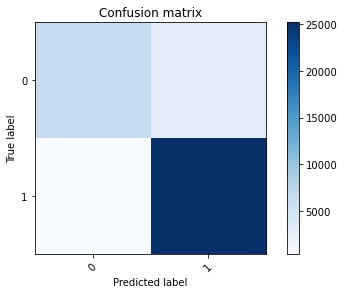

Plotting ROC Curve


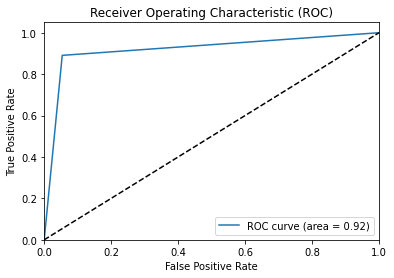

In [19]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)

# fit the model with data
logreg.fit(x, y)

# predict the response for new observations
logR_pred = logreg.predict(x_test)

score_accuracy_lr= metrics.accuracy_score(yLabel, logR_pred)
score_precision_lr=metrics.precision_score(yLabel, logR_pred, average="weighted")
score_recall_lr=metrics.recall_score(yLabel, logR_pred, average="weighted")
score_f1_lr=metrics.f1_score(yLabel, logR_pred, average="weighted")

print("score_accuracy: " ,score_accuracy_lr)
print("score_precision: " ,score_precision_lr)
print("score_recall: " ,score_recall_lr)
print("score_f1: " ,score_f1_lr)

print(classification_report(yLabel,logR_pred))

#mapping confusion matrix
cm = confusion_matrix(yLabel, logR_pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
confusion_matrix_plot(cm, "01")
plt.show()

print('Plotting ROC Curve')
roc_plot(yLabel, logR_pred)

# Nearest Neighbor

In [20]:
#Seperate the dataset and put what you want to predict column and rest other columns
x,y = to_xy(df_training,"label")
y = df_training["label"]

x_test,y_test = to_xy(df_test,"label")

x_test.shape

(35179, 116)

score_accuracy:  0.9569629608573297
score_precision:  0.9578283530391134
score_recall:  0.9569629608573297
score_f1:  0.9560865057756063
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.96      0.93      0.94     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8303  1322]
 [  192 25362]]
Ploting confusion matrix


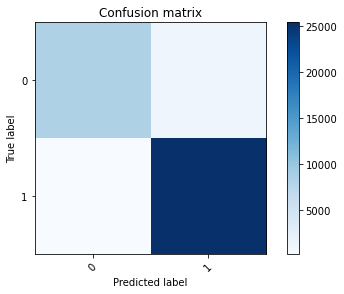

Plotting ROC Curve


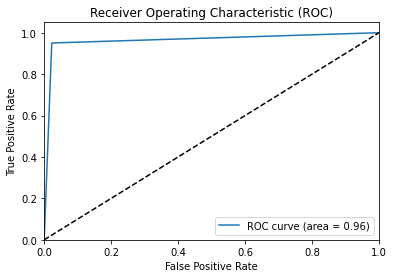

In [21]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(x, y)   #x and y are from training dataset 

knn_pred = knn.predict(x_test)

score_accuracy= metrics.accuracy_score(yLabel, knn_pred)
score_precision=metrics.precision_score(yLabel, knn_pred, average="weighted")
score_recall=metrics.recall_score(yLabel, knn_pred, average="weighted")
score_f1=metrics.f1_score(yLabel, knn_pred, average="weighted")
print("score_accuracy: " ,score_accuracy)
print("score_precision: " ,score_precision)
print("score_recall: " ,score_recall)
print("score_f1: " ,score_f1)

print(classification_report(yLabel,knn_pred))

# Compute confusion matrix
cm = confusion_matrix(yLabel, knn_pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
confusion_matrix_plot(cm, "01")
plt.show()

print('Plotting ROC Curve')
roc_plot(yLabel, knn_pred)

# Neural Network using relu activation and adam optimizer

0
Train on 81173 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 3.74791, saving model to ./best_weights.hdf5
81173/81173 - 15s - loss: 29.1897 - val_loss: 3.7479
Epoch 2/100

Epoch 00002: val_loss did not improve from 3.74791
81173/81173 - 13s - loss: 6.9681 - val_loss: 7.7726
Epoch 3/100

Epoch 00003: val_loss improved from 3.74791 to 0.22593, saving model to ./best_weights.hdf5
81173/81173 - 14s - loss: 1.6827 - val_loss: 0.2259
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.22593
81173/81173 - 16s - loss: 0.2259 - val_loss: 0.2309
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.22593
81173/81173 - 13s - loss: 0.2315 - val_loss: 0.2918
Epoch 6/100

Epoch 00006: val_loss improved from 0.22593 to 0.17632, saving model to ./best_weights.hdf5
81173/81173 - 14s - loss: 0.1920 - val_loss: 0.1763
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.17632
81173/81173 - 14s - loss: 0.1650 - val_loss: 0.1786
Epoch 8/100

Epo

Epoch 2/100

Epoch 00002: val_loss did not improve from 0.07538
81173/81173 - 12s - loss: 6.7913 - val_loss: 1.3105
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.07538
81173/81173 - 12s - loss: 1.2140 - val_loss: 0.5958
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.07538
81173/81173 - 12s - loss: 0.8683 - val_loss: 8.6132
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.07538
81173/81173 - 12s - loss: 0.7573 - val_loss: 0.0864
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.07538
81173/81173 - 12s - loss: 0.2461 - val_loss: 0.2312
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.07538
81173/81173 - 12s - loss: 0.2816 - val_loss: 0.2378
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.07538
81173/81173 - 12s - loss: 0.2153 - val_loss: 0.1489
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.07538
81173/81173 - 12s - loss: 0.1739 - val_loss: 0.2318
Epoch 10/100

Epoch 00010: val_loss did not improve from 0.07538
81173/8

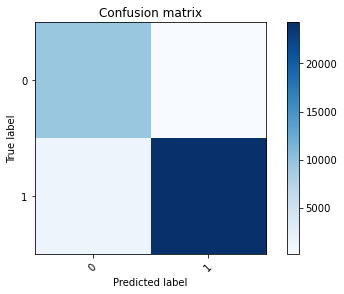

Plotting ROC Curve


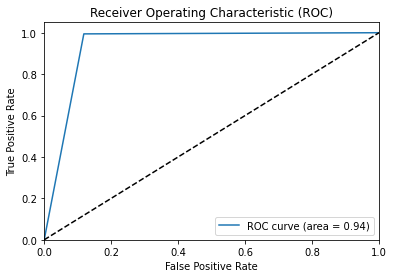

In [33]:
#Create Path and Make Directory
#path = '/dnn/'
#os.mkdir(path)

x,y = to_xy(df_training,'label')
x_test,y_test = to_xy(df_test,'label')

model = Sequential()
#Check pointer
checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", verbose=1, save_best_only=True)

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(64, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    #SAVE THE BEST MODEL 
    model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    
    
print('Training finished...Loading the best model')  
print()
#model.load_weights('dnn/best_weights.hdf5') # load weights from best model

#Measuring accuracy 
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
#print(pred)

#y_true gets the maximum value of y_test. This is done because we are going to compare the maximum value of predicted with it
y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


print(classification_report(y_true, pred))

y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
confusion_matrix_plot(cm, "01")
plt.show()

print('Plotting ROC Curve')
roc_plot(y_true, pred)

In [34]:
# Neural Network using relu activation and sgd optimizer 

0
Train on 81173 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from inf
81173/81173 - 14s - loss: nan - val_loss: nan
Epoch 2/100

Epoch 00002: val_loss did not improve from inf
81173/81173 - 12s - loss: nan - val_loss: nan
Epoch 3/100

Epoch 00003: val_loss did not improve from inf
81173/81173 - 13s - loss: nan - val_loss: nan
Epoch 4/100

Epoch 00004: val_loss did not improve from inf
81173/81173 - 12s - loss: nan - val_loss: nan
Epoch 5/100

Epoch 00005: val_loss did not improve from inf
81173/81173 - 13s - loss: nan - val_loss: nan
Epoch 00005: early stopping
1
Train on 81173 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from inf
81173/81173 - 13s - loss: nan - val_loss: nan
Epoch 2/100

Epoch 00002: val_loss did not improve from inf
81173/81173 - 12s - loss: nan - val_loss: nan
Epoch 3/100

Epoch 00003: val_loss did not improve from inf
81173/81173 - 12s - loss: nan - val_loss: nan
Epoch 4/100

Epoch 0

/Users/sherylbernard/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sherylbernard/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


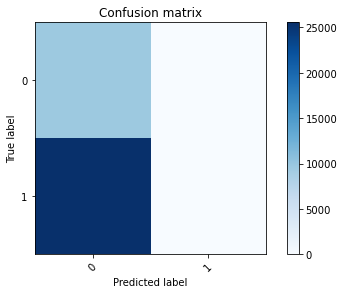

Plotting ROC Curve


/Users/sherylbernard/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


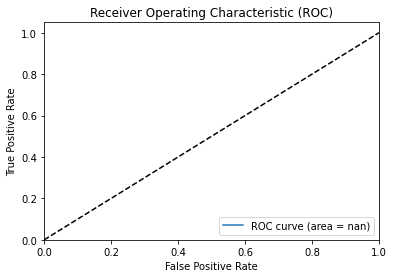

In [35]:
x,y = to_xy(df_training,'label')
x_test,y_test = to_xy(df_test,'label')

model = Sequential()

#Check pointer
checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", verbose=1, save_best_only=True)

for i in range(4):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(60, activation='relu'))    
    model.add(Dense(30, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    #SAVE THE BEST MODEL 
    model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    
    
print('Training finished...Loading the best model')  
print()
#model.load_weights('dnn/best_weights.hdf5') # load weights from best model

#Measuring accuracy 
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)

y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


print(classification_report(y_true, pred))

y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
confusion_matrix_plot(cm, "01")
plt.show()

print('Plotting ROC Curve')
roc_plot(y_true, pred)

In [36]:
# Neural Network using tanh activation and sgd optimizer 

0
Train on 81173 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.29140, saving model to ./best_weights.hdf5
81173/81173 - 9s - loss: 0.3087 - val_loss: 0.2914
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.29140
81173/81173 - 8s - loss: 0.3307 - val_loss: 0.3138
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.29140
81173/81173 - 8s - loss: 0.3362 - val_loss: 0.3061
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.29140
81173/81173 - 8s - loss: 0.3537 - val_loss: 0.3337
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.29140
81173/81173 - 8s - loss: 0.3552 - val_loss: 0.3193
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.29140
81173/81173 - 8s - loss: 0.3486 - val_loss: 0.3445
Epoch 00006: early stopping
1
Train on 81173 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.29140
81173/81173 - 9s - loss: 0.3372 - val_loss: 0.3483
Epoch 2/100

Epoch 00002: 

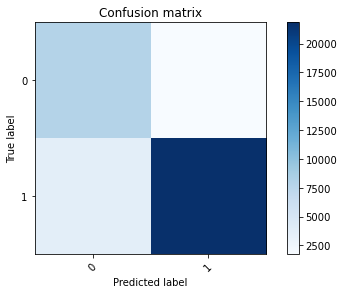

Plotting ROC Curve


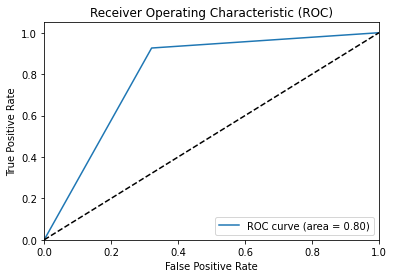

In [37]:
x,y = to_xy(df_training,'label')
x_test,y_test = to_xy(df_test,'label')

model = Sequential()

#Check pointer
checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", verbose=1, save_best_only=True)

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='tanh'))
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    #SAVE THE BEST MODEL 
    model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    
    
print('Training finished...Loading the best model')  
print()
#model.load_weights('dnn/best_weights.hdf5') # load weights from best model

#Measuring accuracy 
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)

y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


print(classification_report(y_true, pred))

y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
confusion_matrix_plot(cm, "01")
plt.show()

print('Plotting ROC Curve')
roc_plot(y_true, pred)